## Part 1: SQL solution

In [2]:
with metrics_calc_30days as
(
	Select mem.user_id,
		   count(bg_value) as count_bgc_last30,
           avg(bg_value) as avg_bgc_last30,
           float(count(bg_value)/30) as avg_bgc_perday_last30,
           sum(case when bg_value < 54 then 1 else 0 end) as count_hypogly_last30
	from members mem
	join blood_glucose_checks bgc
	using(user_id)
	where gender = 'M' 
	  and datediff(year, getdate(), birth_date) >= 18 
      and datediff(day, getdate(), bg_timestamp :: date) <= 30 
	group by user_id
	order by 1
)


Select mem.user_id,
       min(bg_timestamp :: date) as first_bgc_check,
       count_bgc_last30,
       avg_bgc_last30,
       avg_bgc_perday_last30,
       sum(case when bg_value < 54 then 1 else 0 end) as count_hypogly_lifetime,
       count_hypogly_last30

from members mem
join blood_glucose_checks bgc
using(user_id)
left join metrics_calc_30days bgc30
using(user_id)
where gender = 'M' 
  and datediff(year, getdate(), birth_date) >= 18 
group by user_id
order by 1

## Part 2: Python solution

### Load libraries & datasets

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing

In [8]:
cust_data_file = pd.read_csv("C:/Users/Dexter/Desktop/Mrunal/Teladoc/Teladoc Health Data Challenge.csv")

### Explore datasets

In [9]:
cust_data_file.describe() 
cust_data_file.head()

,member_id,diabetes_type,gender,date_utc,bg_checks,avg_bg_value,count_hyper_reading,count_hypo_reading
0,10213339002895,Type 2,Female,2017-08-01,4,157.00000,2,1
1,10213339002895,Type 2,Female,2017-08-02,4,152.61111,1,1
2,10213339002895,Type 2,Female,2017-08-03,1,157.88235,1,0
3,10213339002895,Type 2,Female,2017-08-04,2,162.47058,2,0
4,10213339002895,Type 2,Female,2017-08-05,4,166.22223,2,1


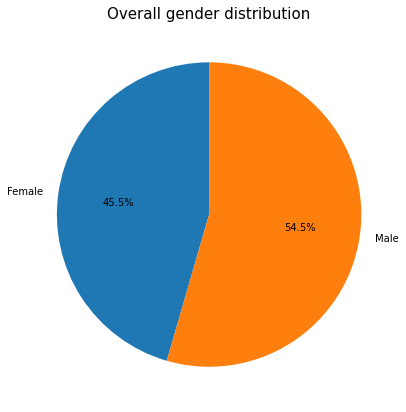

In [12]:
df2 = cust_data_file.groupby(['gender'])['member_id'].size().reset_index(name='member_count')
df2.head()

cust_gender = df2['gender']
count_mem = df2['member_count']
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(count_mem, labels = cust_gender, autopct='%1.1f%%', startangle=90)
 
# show plot
plt.title("Overall gender distribution", fontsize = 15)
plt.show()

### Insight 1: Data is slightly skewed towards male gender

## Hypothesis: Does type of diabetes and gender have any correlation with average glycemic index?

In [28]:
df_cust = cust_data_file.groupby(['diabetes_type','gender'])['avg_bg_value'].mean().reset_index(name = 'avg_bg_val')#.groupby(['diabetes_type','gender']).mean()  
df_cust.head()

,diabetes_type,gender,avg_bg_val
0,Type 1,Female,162.144022
1,Type 1,Male,161.778209
2,Type 2,Female,162.884281
3,Type 2,Male,146.219759


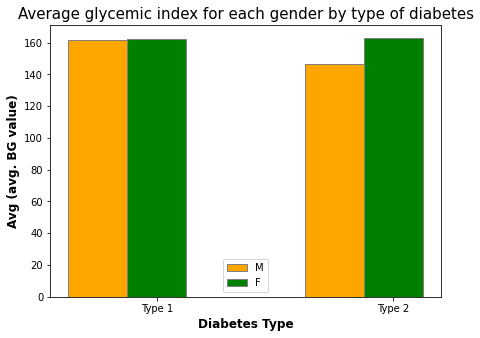

In [43]:
barWidth = 0.25
fig = plt.subplots(figsize =(7, 5))

# Set position of bar on X axis
br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, df_cust[df_cust['gender']=='Male']['avg_bg_val'], color ='orange', width = barWidth,
        edgecolor ='grey', label ='M')
plt.bar(br2, df_cust[df_cust['gender']=='Female']['avg_bg_val'], color ='g', width = barWidth,
        edgecolor ='grey', label ='F')
 
# Adding Xticks
plt.xlabel('Diabetes Type', fontweight ='bold', fontsize = 12)
plt.ylabel('Avg (avg. BG value)', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(2)],
        ['Type 1', 'Type 2'])
 
plt.legend()
plt.title("Average glycemic index for each gender by type of diabetes", fontsize = 15)
plt.show()

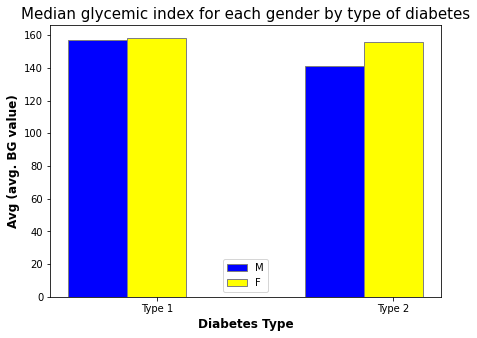

In [46]:
df_cust_median = cust_data_file.groupby(['diabetes_type','gender'])['avg_bg_value'].median().reset_index(name = 'avg_bg_val')#.groupby(['diabetes_type','gender']).mean()  
df_cust_median.head()

barWidth = 0.25
fig = plt.subplots(figsize =(7, 5))

# Set position of bar on X axis
br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, df_cust_median[df_cust_median['gender']=='Male']['avg_bg_val'], color ='blue', width = barWidth,
        edgecolor ='grey', label ='M')
plt.bar(br2, df_cust_median[df_cust_median['gender']=='Female']['avg_bg_val'], color ='yellow', width = barWidth,
        edgecolor ='grey', label ='F')
 
# Adding Xticks
plt.xlabel('Diabetes Type', fontweight ='bold', fontsize = 12)
plt.ylabel('Avg (avg. BG value)', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(2)],
        ['Type 1', 'Type 2'])
 
plt.legend()
plt.title("Median glycemic index for each gender by type of diabetes", fontsize = 15)
plt.show()


### Insight 2: Males with Type 2 diabetes have lower average glycemic index (also verified using median)

### a. What additional data points would you like in order to better analyze our members?

#### - Age information
#### - Other diseases associates that could affect glycemic index such as blood pressure, thyroid etc
#### - Not all members have bg_value listed for all the days. Some of the avg_bg_value cells are missing that would affect the calculation 

### b. What questions would your analysis answer, and why does it matter for our product?
#### This tells us that gender and diabetes condition are not related, need to look at additional data

## Trend charts for analysis

In [48]:
df_cust_trend = cust_data_file.groupby(['diabetes_type','gender','date_utc'])['avg_bg_value'].mean().reset_index(name = 'avg_bg_val')#.groupby(['diabetes_type','gender']).mean()  
df_cust_trend.head(10)

,diabetes_type,gender,date_utc,avg_bg_val
0,Type 1,Female,2017-08-01,169.408093
1,Type 1,Female,2017-08-02,168.516788
2,Type 1,Female,2017-08-03,166.535643
3,Type 1,Female,2017-08-04,166.648293
4,Type 1,Female,2017-08-05,166.121446
5,Type 1,Female,2017-08-06,165.182321
6,Type 1,Female,2017-08-07,162.976501
7,Type 1,Female,2017-08-08,161.224559
8,Type 1,Female,2017-08-09,158.089454
9,Type 1,Female,2017-08-10,158.033239


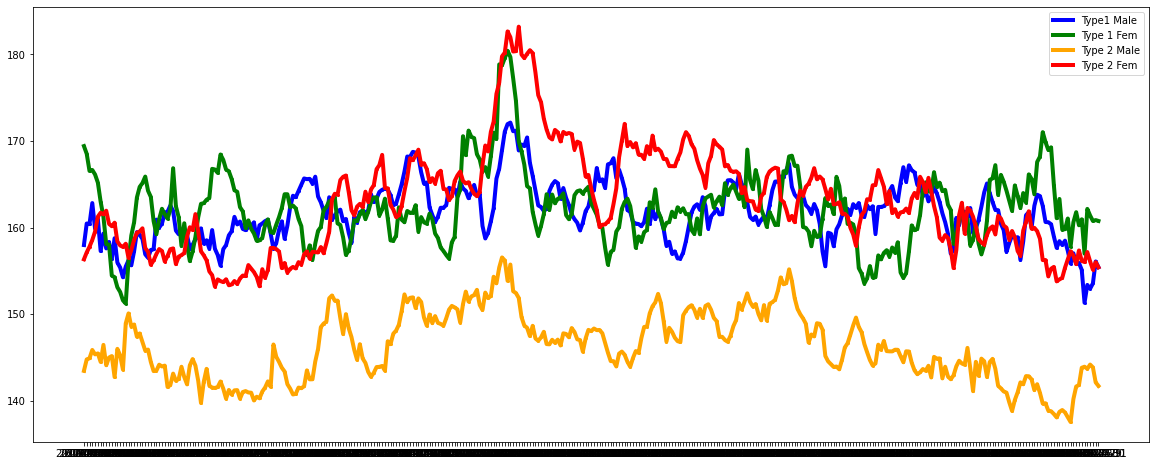

In [72]:
# libraries
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

fig = plt.subplots(figsize =(20, 8))

# df[(df[Gender]=='Male') & (df[Year]==2014)]
df_cust_trend_t1m = df_cust_trend[(df_cust_trend['diabetes_type'] == 'Type 1') & (df_cust_trend['gender'] =='Male')]
df_cust_trend_t1f = df_cust_trend[(df_cust_trend['diabetes_type'] == 'Type 1') & (df_cust_trend['gender'] =='Female')]
df_cust_trend_t2m = df_cust_trend[(df_cust_trend['diabetes_type'] == 'Type 2') & (df_cust_trend['gender'] =='Male')]
df_cust_trend_t2f = df_cust_trend[(df_cust_trend['diabetes_type'] == 'Type 2') & (df_cust_trend['gender'] =='Female')]

# df_cust_trend_t1m.head()
# Data
# multiple line plots
plt.plot('date_utc', 'avg_bg_val', data=df_cust_trend_t1m, marker='o', markerfacecolor='blue', markersize=2, color='blue', linewidth=4, label = 'Type1 Male')
plt.plot('date_utc', 'avg_bg_val', data=df_cust_trend_t1f, marker='o', markerfacecolor='green', markersize=2, color='green', linewidth=4, label = 'Type 1 Fem')
plt.plot('date_utc', 'avg_bg_val', data=df_cust_trend_t2m, marker='o', markerfacecolor='orange', markersize=2, color='orange', linewidth=4, label = 'Type 2 Male')
plt.plot('date_utc', 'avg_bg_val', data=df_cust_trend_t2f, marker='o', markerfacecolor='red', markersize=2, color='red', linewidth=4, label = 'Type 2 Fem')

# plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)
# plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")

# show legend
plt.legend()

# show graph
plt.show()

### Insight 3: During the holiday season, the overall glycemic index spiked across all the members

## Thank you for reading!